In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def grad_champ(im):
    """ Renvoie le gradient d'une image. La taille de retour est 2,H,W,d si la
    taille de l'image est H,W,d"""
    
    out=np.zeros((2,*im.shape),dtype=im.dtype)
    out[0,:,:-1]=im[:,1:]-im[:,:-1]
    out[1,:-1,:]=im[1:,:]-im[:-1,:]
    return out

def div_champ(ch):
    """Renvoies la divergence d'un champ de vecteur. C'est - transposé de
    l'opérateur grad_champ. La sortie est de taille H,W,d si l'entrée est de 
    taille 2,H,W,d"""
    out=np.zeros(ch.shape[1:],dtype=ch.dtype)
    out[:,1:-1]=ch[0,:,1:-1]-ch[0,:,:-2]
    out[:,-1]-=ch[0,:,-2]
    out[:,0]=ch[0,:,0]
    out[1:-1,:]+=ch[1,1:-1,:]-ch[1,:-2,:]
    out[0,:]+=ch[1,0,:]
    out[-1,:]-=ch[1,-2,:]
    
    return out

def prod_scal(X,Y):
    return (X*Y).sum()

def norm_grad_champ(ch):
    """ si entree = 2,H,W,3 la sortie est de taille H,W,3
    on rajoute une fausse dimension 1,H,W,3 pour pouvoir diviser point par point"""
    out=(ch[0]**2+ch[1]**2)**0.5
    return out.reshape((-1,*out.shape))

def projinf(x,lmb):
    Nx=norm_grad_champ(x)
    Nx1=Nx.reshape(-1)
    mask=(Nx>lmb)
    mult=np.ones(Nx.shape,Nx.dtype)
    mult1=mult.reshape(-1)
    mask1=mask.reshape(-1)
    mult1[mask1]=lmb/Nx1[mask1]
    return x*mult

def chambolle(w,lmb,nbpas=100):
    rho=1/12
    x=np.zeros((2,*w.shape),dtype=w.dtype)
    for k in range(nbpas):
        x=projinf(x+rho*grad_champ(div_champ(x)-w),lmb)
    return x

def prox_TV(w,lmb):
    xetoile=chambolle(w,lmb)
    print ('norme de xetoile ',norm2(xetoile))
    return w-div_champ(xetoile)

def grad_F(w,u,divgradu,lmbL,lmbLS):
    lmbL*(w-u)
    
def tirage_thetas(N=10):
    thetas=np.random.randn(N,3)
    tNs=((thetas**2).sum(axis=1,keepdims=True))**0.5
    return thetas/tNs

      

def projette_ordonne(v,theta):
    vals=(v*(theta.reshape((1,1,3)))).sum(axis=-1).reshape(-1)
    vals.sort()
    return vals

def prepare_SW2(v,N=10):
    thetas=tirage_thetas(N=N)
    vords=np.zeros((N,v.shape[0]*v.shape[1]),v.dtype)
    for k in range(N):
        vords[k]=projette_ordonne(v,thetas[k])
    return thetas,vords

def grad_SW2_un_angle(w,vord,theta):
    vals=(w*(theta.reshape((1,1,3)))).sum(axis=-1).reshape(-1)
    idx=vals.argsort()
    idxm1=idx.argsort()
    return (((vals[idx]-vord)[idxm1]).reshape((-1,1))*(theta.reshape((1,3)))).reshape((w.shape[0],w.shape[1],3))

def grad_SW2(w,vords,thetas):
    g=np.zeros(w.shape,w.dtype)
    for k in range(thetas.shape[0]):
        g+=grad_SW2_un_angle(w,vords[k],thetas[k])
    return g/(vords.shape[0]/2)


def norm2(X):
    return (X**2).sum()**0.5
def transfert_couleurs(u,v,nbetapes=100,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10):
    """ transfert les couleurs de v vers l'image u. Renvoie une image couleur de la taille de u"""

    grad_list = []
    
    thetas,vords=prepare_SW2(v,N=N)
    print(f'thetas shape {thetas.shape} vords shape {vords.shape}')
    w=u.copy()
    H=np.zeros((3,3))
    for k in range(N):
        H+=thetas[k].reshape((-1,1))@thetas[k].reshape((1,-1))
    H*=(2.0/N)
    mv=np.linalg.eigh(H)[0][-1]
    tmax=1/(lmbL+lmbS/2*mv)
    tau=tmax/2
    gu=grad_champ(u)
    eps=1e-6
    ngu=norm_grad_champ(gu)+eps
    cst=lmbLS*div_champ(gu/ngu)-lmbL*u
    for k in range(nbetapes):
        print ('Etape numero',k,' sur ', nbetapes)
        #ETAPE E
        gW2=grad_SW2(w,vords,thetas)*(lmbS/2)
        print ('norme de gW2 ',norm2(gW2), 'norme de cst ', norm2(cst))
        grad_tot=(lmbL*w+cst+gW2)
        print('norme grad_tot ',norm2(grad_tot))
        grad_list.append(norm2(grad_tot))
        wk05=w-tau*grad_tot
        #ETAPE I
        w=prox_TV(wk05,tau*lmbR)
        print('norme de la tranlation par prox', norm2(w-wk05))
    return w, grad_list

In [3]:
test=np.random.randn(256,256,3)
gtest=grad_champ(test)

# on verifie que les deux operateurs sont conjugues 
#<grad im | toto>=<im|-div toto> ?
toto=np.random.randn(2,67,89,3)
titi=np.random.randn(67,89,3)
a=prod_scal(grad_champ(titi),toto)
b=prod_scal(titi,div_champ(toto))
print (a+b,a,b)

0.0 -145.89355059625387 145.89355059625387


In [66]:
# vfile='Lenna.png'
# ufile='barbara.jpg'

# ufile='1859578.jpg'
# vfile='1859607.jpg'

# ufile='arecoloriser.png'
# vfile='source_couleur.png'

# ufile='1torecolor.png'
# vfile='1ref.png'

# ufile='res/wall_torecolor_not_masked.png'
# vfile='res/wall_ref.png'

ufile='res/brick_torecolor.png'
vfile='res/brick_ref.png'


v = cv2.imread(vfile, cv2.IMREAD_COLOR).astype(np.float32)
u = cv2.imread(ufile, cv2.IMREAD_COLOR).astype(np.float32)
u=cv2.cvtColor(u,cv2.COLOR_BGR2RGB)
v=cv2.cvtColor(v,cv2.COLOR_BGR2RGB)
# v=v[:215,:176,:] # CAS special parce que 'arecoloriser' et 'source_couleur' n'ont pas la meme taille
v = cv2.resize(v, (u.shape[1], u.shape[0]), interpolation=cv2.INTER_CUBIC)

In [67]:
u.shape,v.shape

((1160, 551, 3), (1160, 551, 3))

In [71]:
uu=np.zeros((u.shape[0]//2,u.shape[1]//2,3))
vv=np.zeros((v.shape[0]//2,v.shape[1]//2,3))
print(uu.shape,vv.shape)
print(u[::2,::2].shape,v[::2,::2].shape)
for k in range(2):
    for l in range(2):
        uu+=u[k::2,l+1::2]
        vv+=v[k::2,l+1::2]
u=uu/4
v=vv/4

(580, 275, 3) (580, 275, 3)
(580, 276, 3) (580, 276, 3)


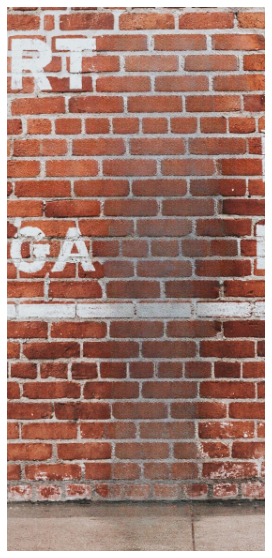

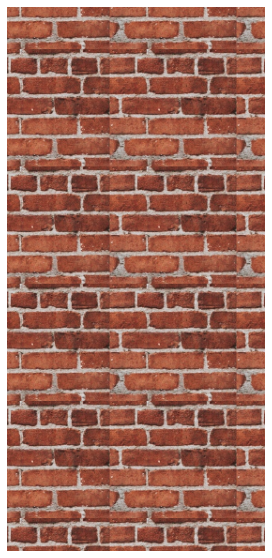

In [72]:
plt.close('all')
plt.figure(figsize=(15,10))
# plt.title('Image to recolor')
plt.axis('off')
plt.imshow(u/255)
plt.figure(figsize=(15,10))
# plt.title('Reference image')
plt.axis('off')
plt.imshow(v/255)

In [8]:
w_L001, grad_list_L001=transfert_couleurs(u,v,nbetapes=30,lmbL=0.01,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_L01, grad_list_L01=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_L1, grad_list_L1=transfert_couleurs(u,v,nbetapes=30,lmbL=1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_L10, grad_list_L10=transfert_couleurs(u,v,nbetapes=30,lmbL=10,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_L100, grad_list_L100=transfert_couleurs(u,v,nbetapes=30,lmbL=100,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)

thetas shape (10, 3) vords shape (10, 116840)
Etape numero 0  sur  30
norme de gW2  3162.302472418765 norme de cst  930.4682655925178
norme grad_tot  3182.620977782736
norme de xetoile  257.8996295631829
norme de la tranlation par prox 400.58137195508067
Etape numero 1  sur  30
norme de gW2  2245.958478714948 norme de cst  930.4682655925178
norme grad_tot  2253.4953392361504
norme de xetoile  257.8875164130011
norme de la tranlation par prox 400.5345387497348
Etape numero 2  sur  30
norme de gW2  1662.0914388292776 norme de cst  930.4682655925178
norme grad_tot  1668.8039613810827
norme de xetoile  257.8724903954366
norme de la tranlation par prox 400.4831689448111
Etape numero 3  sur  30
norme de gW2  1260.650898321088 norme de cst  930.4682655925178
norme grad_tot  1275.8823106423245
norme de xetoile  257.86111059837174
norme de la tranlation par prox 400.44011196138797
Etape numero 4  sur  30
norme de gW2  971.9455164449718 norme de cst  930.4682655925178
norme grad_tot  1003.819240

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

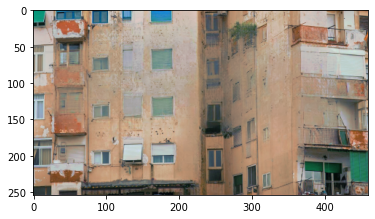

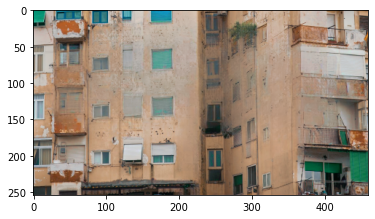

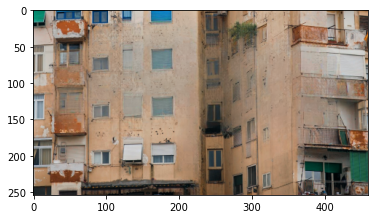

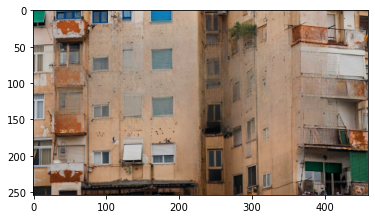

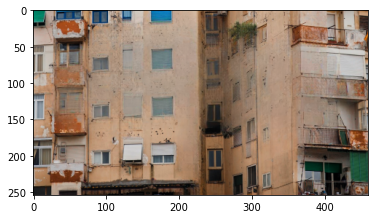

In [9]:
plt.figure()
plt.imshow(w_L001/255)
plt.figure()
plt.imshow(w_L01/255)
plt.figure()
plt.imshow(w_L1/255)
plt.figure()
plt.imshow(w_L10/255)
plt.figure()
plt.imshow(w_L100/255)

cv2.imwrite('resultat_L001.png',cv2.cvtColor(w_L001.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_L01.png',cv2.cvtColor(w_L01.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_L1.png',cv2.cvtColor(w_L1.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_L10.png',cv2.cvtColor(w_L10.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_L100.png',cv2.cvtColor(w_L100.astype(np.float32),cv2.COLOR_RGB2BGR))

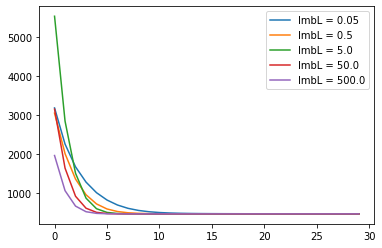

In [11]:
grad_list_L = [grad_list_L001, grad_list_L01, grad_list_L1, grad_list_L10, grad_list_L100]

# Plot all curves from grad_list_L on a single plot
fig, ax = plt.subplots()
for i in range(len(grad_list_L)):
    ax.plot(grad_list_L[i], label='lmbL = ' + str(0.05 * 10**i))
ax.legend()
plt.show()


# plt.figure()
# plt.plot(grad_list_L001)

# plt.figure()
# plt.plot(grad_list_L01)

# plt.figure()
# plt.plot(grad_list_L1)

# plt.figure()
# plt.plot(grad_list_L10)

# plt.figure()
# plt.plot(grad_list_L100)

## Variation of $\lambda_R$

In [12]:
w_R005, grad_list_R005=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.05,lmbLS=0.5,lmbS=1,N=10)
w_R05, grad_list_R05=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_R5, grad_list_R5=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=5,lmbLS=0.5,lmbS=1,N=10)
w_R50, grad_list_R50=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=50,lmbLS=0.5,lmbS=1,N=10)
w_R500, grad_list_R500=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=500,lmbLS=0.5,lmbS=1,N=10)

thetas shape (10, 3) vords shape (10, 116840)
Etape numero 0  sur  30
norme de gW2  3761.8078901954595 norme de cst  7851.372562006716
norme grad_tot  3781.3500942838023
norme de xetoile  25.907894174732228
norme de la tranlation par prox 42.33082774324239
Etape numero 1  sur  30
norme de gW2  2492.4560214808757 norme de cst  7851.372562006716
norme grad_tot  2196.1799590988353
norme de xetoile  25.907985132696478
norme de la tranlation par prox 43.323527037227926
Etape numero 2  sur  30
norme de gW2  1780.7604066856177 norme de cst  7851.372562006716
norme grad_tot  1314.9758343107671
norme de xetoile  25.90796315846672
norme de la tranlation par prox 43.95613228656474
Etape numero 3  sur  30
norme de gW2  1379.9001489125333 norme de cst  7851.372562006716
norme grad_tot  830.9019177174442
norme de xetoile  25.907823142250486
norme de la tranlation par prox 44.39928897273281
Etape numero 4  sur  30
norme de gW2  1151.8268611248584 norme de cst  7851.372562006716
norme grad_tot  568.77

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

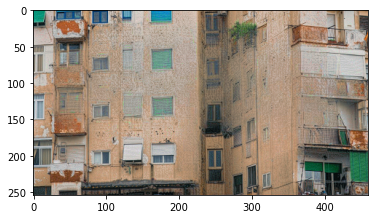

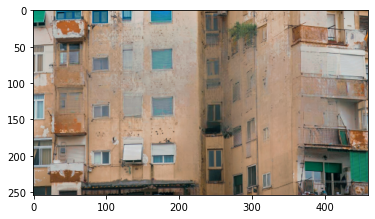

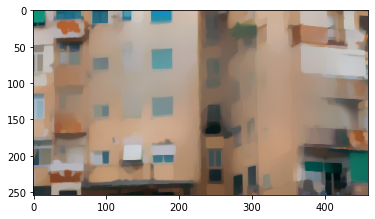

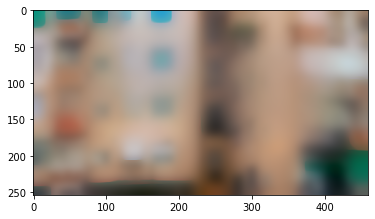

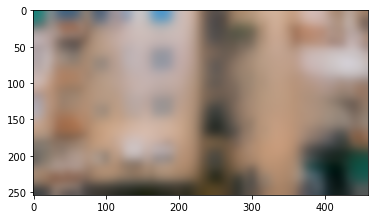

In [13]:
plt.figure()
plt.imshow(w_R005/255)
plt.figure()
plt.imshow(w_R05/255)
plt.figure()
plt.imshow(w_R5/255)
plt.figure()
plt.imshow(w_R50/255)
plt.figure()
plt.imshow(w_R500/255)

cv2.imwrite('resultat_R005.png',cv2.cvtColor(w_R005.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_R05.png',cv2.cvtColor(w_R05.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_R5.png',cv2.cvtColor(w_R5.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_R50.png',cv2.cvtColor(w_R50.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_R500.png',cv2.cvtColor(w_R500.astype(np.float32),cv2.COLOR_RGB2BGR))

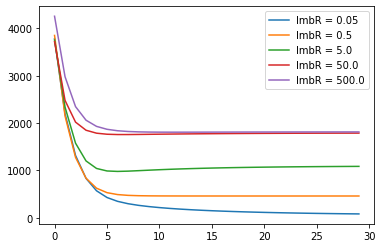

In [14]:
grad_list_R = [grad_list_R005, grad_list_R05, grad_list_R5, grad_list_R50, grad_list_R500]

# plot all curves from grad_list_R in a single plot
fig, ax = plt.subplots()
for i in range(len(grad_list_R)):
    ax.plot(grad_list_R[i], label='lmbR = ' + str(0.05 * 10**i))
ax.legend()
plt.show()

## Variation of $\lambda_{LS}$

In [89]:
w_LS1, grad_list_LS1=transfert_couleurs(u,v,nbetapes=25,lmbL=0.5,lmbR=0.5,lmbLS=0.5,lmbS=100,N=10)

thetas shape (10, 3) vords shape (10, 159500)
Etape numero 0  sur  25
norme de gW2  407596.28457641625 norme de cst  46512.54711006577
norme grad_tot  407540.0835320854
norme de xetoile  3.5441789548953517
norme de la tranlation par prox 6.240431061061572
Etape numero 1  sur  25
norme de gW2  249050.02482796911 norme de cst  46512.54711006577
norme grad_tot  246934.07446414552
norme de xetoile  3.5441752046058985
norme de la tranlation par prox 6.244248902313772
Etape numero 2  sur  25
norme de gW2  163342.08783025065 norme de cst  46512.54711006577
norme grad_tot  160073.01677688755
norme de xetoile  3.544165386132699
norme de la tranlation par prox 6.247401302343106
Etape numero 3  sur  25
norme de gW2  114200.28551303768 norme de cst  46512.54711006577
norme grad_tot  110304.5348429056
norme de xetoile  3.5441642896406367
norme de la tranlation par prox 6.249918926051648
Etape numero 4  sur  25
norme de gW2  83975.01054893504 norme de cst  46512.54711006577
norme grad_tot  79750.379

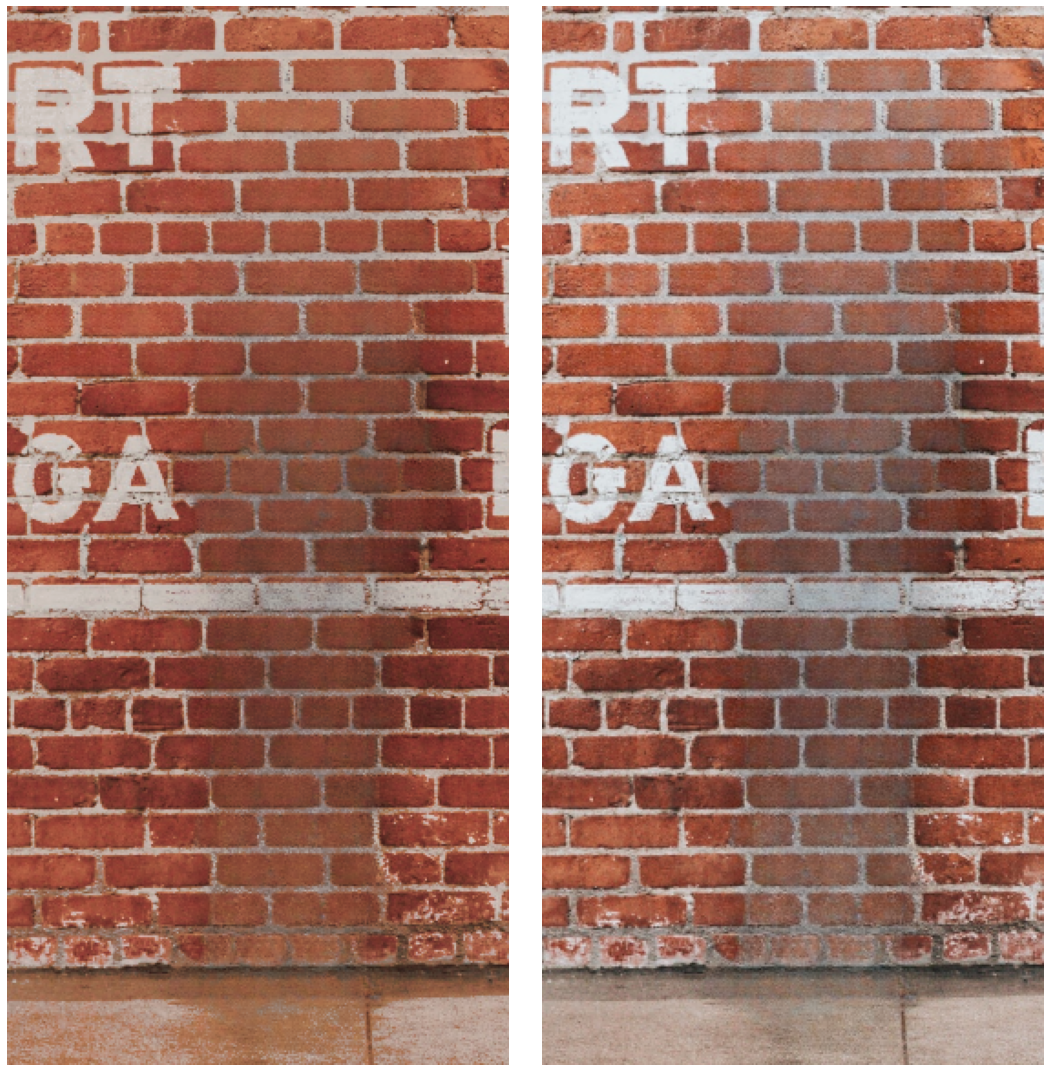

In [90]:
# augment contrast of W_LS1 with pyramid
# w_LS1_test = cv2.pyrUp(w_LS1)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(w_LS1/255)
ax[0].axis('off')
ax[1].imshow(u/255)
ax[1].axis('off')
plt.tight_layout()

# plt.figure()
# plt.imshow(w_LS1/255)

In [84]:
cv2.imwrite('resultat_def_mask.png',cv2.cvtColor(w_LS1.astype(np.float32),cv2.COLOR_RGB2BGR))

True

In [18]:
w_LS005, grad_list_LS005=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.05,lmbS=1,N=10)
w_LS05, grad_list_LS05=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_LS5, grad_list_LS5=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=5,lmbS=1,N=10)
w_LS50, grad_list_LS50=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=50,lmbS=1,N=10)
w_LS500, grad_list_LS500=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=500,lmbS=1,N=10)

thetas shape (10, 3) vords shape (10, 116840)
Etape numero 0  sur  30
norme de gW2  2596.0367797681665 norme de cst  7812.223760276265
norme grad_tot  2595.2975979873304
norme de xetoile  262.95983389302205
norme de la tranlation par prox 376.2158057253989
Etape numero 1  sur  30
norme de gW2  1913.0072722740085 norme de cst  7812.223760276265
norme grad_tot  1684.1395692367328
norme de xetoile  261.96403208461845
norme de la tranlation par prox 344.20489717929644
Etape numero 2  sur  30
norme de gW2  1514.673722779277 norme de cst  7812.223760276265
norme grad_tot  1144.9594459014502
norme de xetoile  260.8519497924243
norme de la tranlation par prox 320.83890639050145
Etape numero 3  sur  30
norme de gW2  1266.474977219983 norme de cst  7812.223760276265
norme grad_tot  808.3424623281794
norme de xetoile  259.7796956470561
norme de la tranlation par prox 303.7048070465273
Etape numero 4  sur  30
norme de gW2  1103.6636303722346 norme de cst  7812.223760276265
norme grad_tot  589.9665

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

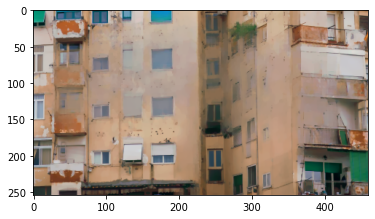

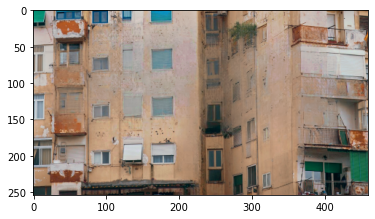

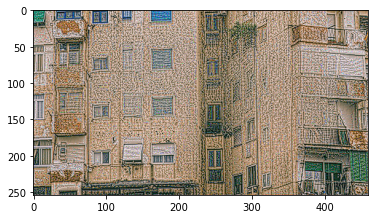

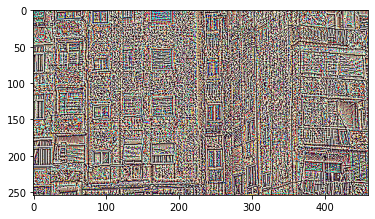

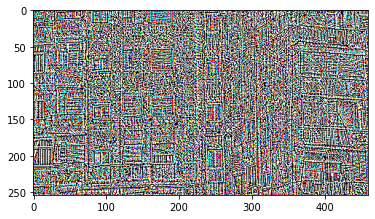

In [19]:
plt.figure()
plt.imshow(w_LS005/255)
plt.figure()
plt.imshow(w_LS05/255)
plt.figure()
plt.imshow(w_LS5/255)
plt.figure()
plt.imshow(w_LS50/255)
plt.figure()
plt.imshow(w_LS500/255)

cv2.imwrite('resultat_LS005.png',cv2.cvtColor(w_LS005.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_LS05.png',cv2.cvtColor(w_LS05.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_LS5.png',cv2.cvtColor(w_LS5.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_LS50.png',cv2.cvtColor(w_LS50.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_LS500.png',cv2.cvtColor(w_LS500.astype(np.float32),cv2.COLOR_RGB2BGR))

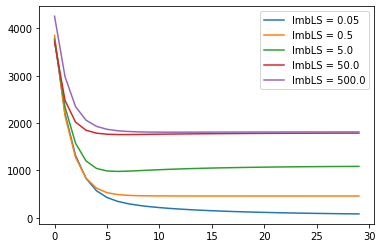

In [20]:
grad_list_LS = [grad_list_R005, grad_list_R05, grad_list_R5, grad_list_R50, grad_list_R500]

# plot all curves from grad_list_LS in a single plot
fig, ax = plt.subplots()
for i in range(len(grad_list_LS)):
    ax.plot(grad_list_LS[i], label='lmbLS = ' + str(0.05 * 10**i))
ax.legend()
plt.show()

## Variation of $\lambda_S$

In [21]:
w_S001, grad_list_S001=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=0.01,N=10)
w_S01, grad_list_S01=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=0.1,N=10)
w_S1, grad_list_S1=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=1,N=10)
w_S10, grad_list_S10=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=10,N=10)
w_S100, grad_list_S100=transfert_couleurs(u,v,nbetapes=30,lmbL=0.1,lmbR=0.5,lmbLS=0.5,lmbS=100,N=10)

thetas shape (10, 3) vords shape (10, 116840)
Etape numero 0  sur  30
norme de gW2  32.030721849037626 norme de cst  7851.372562006716
norme grad_tot  459.5546523651091
norme de xetoile  1412.6651632323933
norme de la tranlation par prox 2194.40585016343
Etape numero 1  sur  30
norme de gW2  31.425934763406058 norme de cst  7851.372562006716
norme grad_tot  459.18129222454786
norme de xetoile  1412.6652748070417
norme de la tranlation par prox 2194.39920795623
Etape numero 2  sur  30
norme de gW2  31.122581735331377 norme de cst  7851.372562006716
norme grad_tot  459.20111120416414
norme de xetoile  1412.6653360777657
norme de la tranlation par prox 2194.3984434711383
Etape numero 3  sur  30
norme de gW2  30.970340157307472 norme de cst  7851.372562006716
norme grad_tot  459.26386506782364
norme de xetoile  1412.6653433612219
norme de la tranlation par prox 2194.39837901222
Etape numero 4  sur  30
norme de gW2  30.893921713157347 norme de cst  7851.372562006716
norme grad_tot  459.3088

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

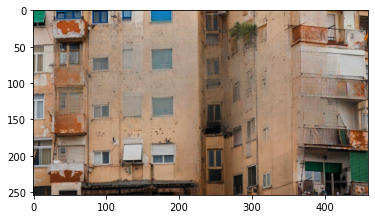

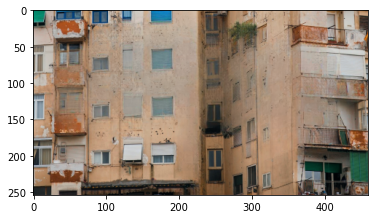

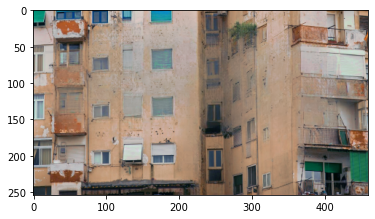

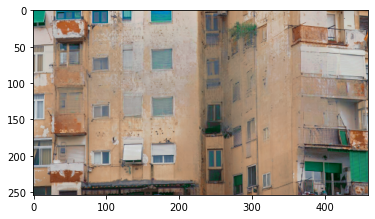

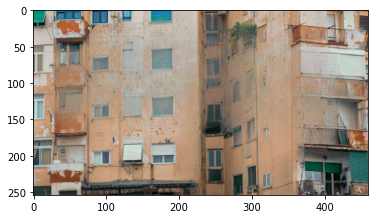

In [22]:
plt.figure()
plt.imshow(w_S001/255)
plt.figure()
plt.imshow(w_S01/255)
plt.figure()
plt.imshow(w_S1/255)
plt.figure()
plt.imshow(w_S10/255)
plt.figure()
plt.imshow(w_S100/255)

cv2.imwrite('resultat_S001.png',cv2.cvtColor(w_S001.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_S01.png',cv2.cvtColor(w_S01.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_S1.png',cv2.cvtColor(w_S1.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_S10.png',cv2.cvtColor(w_S10.astype(np.float32),cv2.COLOR_RGB2BGR))
cv2.imwrite('resultat_S100.png',cv2.cvtColor(w_S100.astype(np.float32),cv2.COLOR_RGB2BGR))

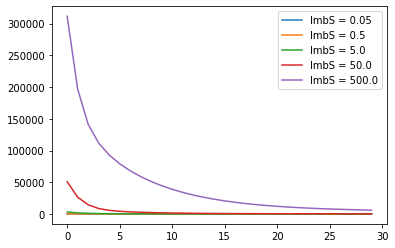

In [23]:
grad_list_S = [grad_list_S001, grad_list_S01, grad_list_S1, grad_list_S10, grad_list_S100]

# plot all curves from grad_list_LS in a single plot
fig, ax = plt.subplots()
for i in range(len(grad_list_S)):
    ax.plot(grad_list_S[i], label='lmbS = ' + str(0.05 * 10**i))
ax.legend()
plt.show()